<div class = "row">
    <div class = "colums">
        <img src="..\trecslogo.png" align="left" alt="Drawing" width ="60"/>    
    </div>
    <div class = "colums">
        <img src="..\asrlogo.png" align="right" alt="Drawing" width ="175"/>
    </div>    
</div>

# SWAPTION

## Algemeen

### Import en instellingen

In [52]:
import pandas as pd
import numpy as np
import datetime
import math
from scipy.optimize import fsolve
from scipy.stats import norm
from matplotlib import pyplot as plt

Links uitlijnen tabellen

In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

Bij printen van een dataframe wordt slechts een beperkt aantal rijen getoond.

In [3]:
pd.set_option('display.max_rows', 100)

## Initialisatie parameters

In [4]:
# data
datePricingPrimo = '20220331' # in dit notebook veronderstel ik dat de actuele datum dezelfde is als de kwartaal datum
datePricingUltimo = '20220430'
datePricingPrimo = datetime.datetime.strptime(datePricingPrimo, '%Y%m%d')
datePricingUltimo = datetime.datetime.strptime(datePricingUltimo, '%Y%m%d')

# naam van de basis curve
curveNameBasis = 'FairValue'

# Bachelier model (instead of H&W)
Bachelier = True

# Haug formula for cash sattled swaptions assumes that 6 month compounded swap rate used as the discounting rate
m = 2

## Importeer en bewerk data

### Volatiliteit schokken

#### Delta volatiliteit primo

In [5]:
df_scenariosPrimo = pd.read_excel(r"scenariobestanden/scenariosAssetsM03.xlsx", decimal = '.')
df_schokVolatiliteitPrimo = df_scenariosPrimo.loc[df_scenariosPrimo['Item'] == 'schokVolatiliteit']
df_schokVolatiliteitPrimo

,Item,Currency,FairValue,swap.cra.zero.va.down,swap.cra.zero.va.up,SII_basis,SII_Yield_Curve_down,SII_Yield_Curve_up,SII_basis.EQUITY_TYPE_1,SII_basis.EQUITY_TYPE_2,...,swap.cra.eur-stylized-1.zero.va.sw345.down345,swap.cra.eur-stylized-1.zero.va.sw345.up345,swap.cra.dnb,swap.cra.dnb.up,swap.cra.dnb.down,swap.cra.zero.va-ratio50.sw270,swap.cra.zero.va-ratio50.sw270.down270,swap.cra.zero.va-ratio50.sw270.up270,swap.cra.zero.va-ratio50.sw270_Currency_Up,swap.cra.zero.va-ratio50.sw270_Currency_Down
0,schokVolatiliteit,EUR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Delta volatiliteit ultimo

In [6]:
df_scenariosUltimo = pd.read_excel(r"scenariobestanden/scenariosAssetsM04.xlsx", decimal = '.')
df_schokVolatiliteitUltimo = df_scenariosUltimo.loc[df_scenariosUltimo['Item'] == 'schokVolatiliteit']
df_schokVolatiliteitUltimo

,Item,Currency,FairValue,swap.cra.zero.va.down,swap.cra.zero.va.up,SII_basis,SII_Yield_Curve_down,SII_Yield_Curve_up,SII_basis.EQUITY_TYPE_1,SII_basis.EQUITY_TYPE_2,...,swap.cra.eur-pc-1.zero.va.sw345.up345,swap.cra.eur-pc-2.zero.va.sw345.down345,swap.cra.eur-pc-2.zero.va.sw345.up345,swap.cra.eur-pc-3.zero.va.sw345.down345,swap.cra.eur-pc-3.zero.va.sw345.up345,swap.cra.eur-stylized-1.zero.va.sw345.down345,swap.cra.eur-stylized-1.zero.va.sw345.up345,swap.cra.dnb,swap.cra.dnb.up,swap.cra.dnb.down
0,schokVolatiliteit,EUR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Rentecurves
In de TRT is een begin gemaakt om te rekenen met de dual curve methodiek, dus op basis van de zero swap curve en de zero EONIA curve. Dit moet in TRT nog verder worden uitgewerkt en is nog niet operationeel. Dit notebook is daarom vooralsnog obv single curve methodiek (net zoals TRT).

#### Rentecurves primo

In [7]:
df_curvesPrimo = df_scenariosPrimo.loc[df_scenariosPrimo['Item'] != 'schokVolatiliteit']
df_curvesPrimo = df_curvesPrimo.reset_index(drop=True)
pd.options.display.float_format = '{:,.8f}'.format
df_curvesPrimo

,Item,Currency,FairValue,swap.cra.zero.va.down,swap.cra.zero.va.up,SII_basis,SII_Yield_Curve_down,SII_Yield_Curve_up,SII_basis.EQUITY_TYPE_1,SII_basis.EQUITY_TYPE_2,...,swap.cra.eur-stylized-1.zero.va.sw345.down345,swap.cra.eur-stylized-1.zero.va.sw345.up345,swap.cra.dnb,swap.cra.dnb.up,swap.cra.dnb.down,swap.cra.zero.va-ratio50.sw270,swap.cra.zero.va-ratio50.sw270.down270,swap.cra.zero.va-ratio50.sw270.up270,swap.cra.zero.va-ratio50.sw270_Currency_Up,swap.cra.zero.va-ratio50.sw270_Currency_Down
0,1,EUR,-0.00080869,-0.00080869,0.00919131,-0.00080869,-0.00080869,0.00919131,-0.00080869,-0.00080869,...,-0.00080776,0.00919224,-0.00080869,0.00919131,-0.00080869,-0.00080869,-0.00080869,0.00919131,-0.00080869,-0.00080869
1,2,EUR,0.00537754,0.00253036,0.01537754,0.00537754,0.00254137,0.01537754,0.00537754,0.00537754,...,0.00254794,0.01538412,0.00537754,0.01537754,0.00253036,0.00537754,0.00254137,0.01537754,0.00537754,0.00537754
2,3,EUR,0.00806788,0.00411486,0.01806788,0.00806788,0.00412935,0.01806788,0.00806788,0.00806788,...,0.00413130,0.01806983,0.00806788,0.01806788,0.00411486,0.00806788,0.00412935,0.01806788,0.00806788,0.00806788
3,4,EUR,0.00926595,0.00510382,0.01926595,0.00926595,0.00511846,0.01926595,0.00926595,0.00926595,...,0.00511910,0.01926659,0.00926595,0.01926595,0.00510382,0.00926595,0.00511846,0.01926595,0.00926595,0.00926595
4,5,EUR,0.00990248,0.00577112,0.01990248,0.00990248,0.00578518,0.01990248,0.00990248,0.00990248,...,0.00578534,0.01990264,0.00990248,0.01990248,0.00577112,0.00990248,0.00578518,0.01990248,0.00990248,0.00990248
5,6,EUR,0.01037414,0.00640208,0.02037414,0.01037414,0.00641534,0.02037414,0.01037414,0.01037414,...,0.00641525,0.02037405,0.01037414,0.02037414,0.00640208,0.01037414,0.00641534,0.02037414,0.01037414,0.01037414
6,7,EUR,0.01078707,0.00693993,0.02078707,0.01078707,0.00695264,0.02078707,0.01078707,0.01078707,...,0.00695239,0.02078682,0.01078707,0.02078707,0.00693993,0.01078707,0.00695264,0.02078707,0.01078707,0.01078707
7,8,EUR,0.01120210,0.00749941,0.02120210,0.01120210,0.00751155,0.02120210,0.01120210,0.01120210,...,0.00751119,0.02120174,0.01120210,0.02120210,0.00749941,0.01120210,0.00751155,0.02120210,0.01120210,0.01120210
8,9,EUR,0.01161711,0.00808305,0.02161711,0.01161711,0.00809461,0.02161711,0.01161711,0.01161711,...,0.00809416,0.02161665,0.01161711,0.02161711,0.00808305,0.01161711,0.00809461,0.02161711,0.01161711,0.01161711
9,10,EUR,0.01205979,0.00861073,0.02205979,0.01205979,0.00862207,0.02205979,0.01205979,0.01205979,...,0.00862154,0.02205925,0.01205979,0.02205979,0.00861073,0.01205979,0.00862207,0.02205979,0.01205979,0.01205979


In [8]:
curveNamesPrimo = list(df_curvesPrimo.columns)[2:]
# curveNamesPrimo = ['FairValue', 'swap.cra.zero.va.down']
curveNamesPrimo

['FairValue',
 'swap.cra.zero.va.down',
 'swap.cra.zero.va.up',
 'SII_basis',
 'SII_Yield_Curve_down',
 'SII_Yield_Curve_up',
 'SII_basis.EQUITY_TYPE_1',
 'SII_basis.EQUITY_TYPE_2',
 'SII_basis.EQUITY_QUINF',
 'SII_basis.EQUITY_QUINFC',
 'SII_basis.EQUITY_Average',
 'SCR_Average_zonder_OMA',
 'SCR_Average_OMA_Q2',
 'SCR_Average_OMA_Q4',
 'SII_Real_Estate',
 'SCR_Currency_Up',
 'SCR_Currency_Down',
 'ECAP_basis',
 'ECAP_Yield_Curve_down',
 'ECAP_Yield_Curve_up',
 'ECAP_basis.EQUITY_VM_EURO',
 'ECAP_basis.EQUITY_Deelnemingen',
 'ECAP_basis.EQUITY_Alternatives',
 'ECAP_basis.EQUITY_Emerging_Markets',
 'ECAP_basis.EQUITY_VM_NON_EURO',
 'ECAP_Real_Estate',
 'ECAP_Currency_Up',
 'ECAP_Currency_Down',
 'SII_Real_Estate_-10procent',
 'Vastgoed_-10procent',
 'Aandelen_-20procent.EQUITY_TYPE_1',
 'Aandelen_-20procent.EQUITY_TYPE_2',
 'Aandelen_-20procent.EQUITY_QUINF',
 'Aandelen_-20procent.EQUITY_QUINFC',
 'Aandelen_-20procent.EQUITY_Average',
 'Aandelen_-20procent',
 'swap.cra.zero.va.plus20bp

#### Rentecurves ultimo

In [9]:
df_curvesUltimo = df_scenariosUltimo.loc[df_scenariosPrimo['Item'] != 'schokVolatiliteit']
df_curvesUltimo = df_curvesUltimo.reset_index(drop=True)
pd.options.display.float_format = '{:,.8f}'.format
df_curvesUltimo

,Item,Currency,FairValue,swap.cra.zero.va.down,swap.cra.zero.va.up,SII_basis,SII_Yield_Curve_down,SII_Yield_Curve_up,SII_basis.EQUITY_TYPE_1,SII_basis.EQUITY_TYPE_2,...,swap.cra.eur-pc-1.zero.va.sw345.up345,swap.cra.eur-pc-2.zero.va.sw345.down345,swap.cra.eur-pc-2.zero.va.sw345.up345,swap.cra.eur-pc-3.zero.va.sw345.down345,swap.cra.eur-pc-3.zero.va.sw345.up345,swap.cra.eur-stylized-1.zero.va.sw345.down345,swap.cra.eur-stylized-1.zero.va.sw345.up345,swap.cra.dnb,swap.cra.dnb.up,swap.cra.dnb.down
0,1,EUR,0.00259943,0.00139120,0.01259943,0.00259943,0.00139193,0.01259943,0.00259943,0.00259943,...,0.01725770,-0.00356682,0.00643318,0.00102778,0.01115760,0.00138902,0.01259652,0.00259943,0.01259943,0.00139120
1,2,EUR,0.00969469,0.00402633,0.01969469,0.00969469,0.00405226,0.01969469,0.00969469,0.00969469,...,0.02438614,0.00227814,0.01462605,0.00375812,0.01884818,0.00405780,0.01970023,0.00969469,0.01969469,0.00402633
2,3,EUR,0.01243270,0.00606463,0.02243270,0.01243270,0.00609550,0.02243270,0.01243270,0.01243270,...,0.02735691,0.00427634,0.01830597,0.00597806,0.02216739,0.00609468,0.02243187,0.01243270,0.02243270,0.00606463
3,4,EUR,0.01369587,0.00734868,0.02369587,0.01369587,0.00737977,0.02369587,0.01369587,0.01369587,...,0.02860229,0.00572066,0.02038351,0.00744146,0.02382117,0.00737756,0.02369367,0.01369587,0.02369587,0.00734868
4,5,EUR,0.01448096,0.00827133,0.02448096,0.01448096,0.00830175,0.02448096,0.01448096,0.01448096,...,0.02918091,0.00687420,0.02184220,0.00851795,0.02488322,0.00829919,0.02447839,0.01448096,0.02448096,0.00827133
5,6,EUR,0.01514804,0.00920293,0.02514804,0.01514804,0.00923207,0.02514804,0.01514804,0.01514804,...,0.02985017,0.00802781,0.02307610,0.00956821,0.02572966,0.00922935,0.02514533,0.01514804,0.02514804,0.00920293
6,7,EUR,0.01575618,0.00999795,0.02575618,0.01575618,0.01002618,0.02575618,0.01575618,0.01575618,...,0.03046035,0.00903296,0.02413242,0.01044695,0.02644840,0.01002340,0.02575340,0.01575618,0.02575618,0.00999795
7,8,EUR,0.01635679,0.01081972,0.02635679,0.01635679,0.01084695,0.02635679,0.01635679,0.01635679,...,0.03106300,0.01004523,0.02510881,0.01132235,0.02710245,0.01084413,0.02635396,0.01635679,0.02635679,0.01081972
8,9,EUR,0.01693788,0.01166746,0.02693788,0.01693788,0.01169358,0.02693788,0.01693788,0.01693788,...,0.03164608,0.01106177,0.02599990,0.01221072,0.02771290,0.01169073,0.02693503,0.01693788,0.02693788,0.01166746
9,10,EUR,0.01751541,0.01239639,0.02751541,0.01751541,0.01242205,0.02751541,0.01751541,0.01751541,...,0.03222560,0.01194793,0.02683382,0.01295935,0.02829755,0.01241917,0.02751254,0.01751541,0.02751541,0.01239639


In [10]:
curveNamesUltimo = list(df_curvesUltimo.columns)[2:]
# curveNamesUltimo = ['FairValue', 'swap.cra.zero.va.down']
curveNamesUltimo

['FairValue',
 'swap.cra.zero.va.down',
 'swap.cra.zero.va.up',
 'SII_basis',
 'SII_Yield_Curve_down',
 'SII_Yield_Curve_up',
 'SII_basis.EQUITY_TYPE_1',
 'SII_basis.EQUITY_TYPE_2',
 'SII_basis.EQUITY_QUINF',
 'SII_basis.EQUITY_QUINFC',
 'SII_basis.EQUITY_Average',
 'SCR_Average_zonder_OMA',
 'SCR_Average_OMA_Q2',
 'SCR_Average_OMA_Q4',
 'SII_Real_Estate',
 'SCR_Currency_Up',
 'SCR_Currency_Down',
 'ECAP_basis',
 'ECAP_Yield_Curve_down',
 'ECAP_Yield_Curve_up',
 'ECAP_basis.EQUITY_VM_EURO',
 'ECAP_basis.EQUITY_Deelnemingen',
 'ECAP_basis.EQUITY_Alternatives',
 'ECAP_basis.EQUITY_Emerging_Markets',
 'ECAP_basis.EQUITY_VM_NON_EURO',
 'ECAP_Real_Estate',
 'ECAP_Currency_Up',
 'ECAP_Currency_Down',
 'SII_Real_Estate_-10procent',
 'Vastgoed_-10procent',
 'Aandelen_-20procent.EQUITY_TYPE_1',
 'Aandelen_-20procent.EQUITY_TYPE_2',
 'Aandelen_-20procent.EQUITY_QUINF',
 'Aandelen_-20procent.EQUITY_QUINFC',
 'Aandelen_-20procent.EQUITY_Average',
 'Aandelen_-20procent',
 'swap.cra.zero.va.plus20bp

### IMW bestand

CIC codes swaptions:

- B6 = Call options granting its owner the right but not the obligation to enter into a long position in an underlying swap, i.e., enter into a swap where the owner pays the fixed leg and receive the floating leg
- C6 = Put options granting its owner the right but not the obligation to enter into a short position in an underlying swap, i.e., enter into a swap in which the owner will receive the fixed leg, and pay the floating leg

#### IMW bestand primo

In [11]:
col_list = ['Reporting Date', 'Ecs Cons Ecap asr', 'Portfolio Id', 'Cic Id Ll', 'Market Value EUR LL', 'BalNomVal LT', 'Strike Price Laagste Level', 'Maturity Call LL', 'Maturity LL', 'Security Id Ll', 'Security Type Ll', 'Volatility dim']
df_swaptionsIMWPrimo = pd.read_csv(r"imwbestand/2022M03 Adjusted IMW Weekupdate 202205131221.csv", usecols = col_list, sep = ";", decimal = '.', encoding= 'unicode_escape', low_memory=False)

In [12]:
df_swaptionsIMWPrimo = df_swaptionsIMWPrimo.loc[df_swaptionsIMWPrimo['Security Type Ll'] == 'SWAPTION']
df_swaptionsIMWPrimo = df_swaptionsIMWPrimo.reset_index(drop=True)

In [13]:
df_swaptionsIMWPrimo['dateIMW'] = pd.to_datetime(df_swaptionsIMWPrimo['Reporting Date'], format='%Y%m%d')
df_swaptionsIMWPrimo['dateSwapExpiry'] = pd.to_datetime(df_swaptionsIMWPrimo['Maturity LL'], format='%Y%m%d')
df_swaptionsIMWPrimo['dateSwaptionExpiry'] = pd.to_datetime(df_swaptionsIMWPrimo['Maturity Call LL'], format='%Y%m%d')
df_swaptionsIMWPrimo = df_swaptionsIMWPrimo.drop(['Reporting Date', 'Security Type Ll', 'Maturity LL', 'Maturity Call LL'], axis = 1)

In [14]:
df_swaptionsIMWPrimo.rename(columns = { \
                              'Cic Id Ll':'cicCode', \
                              'Ecs Cons Ecap asr': 'company', \
                              'Security Id Ll':'securityId', \
                              'Portfolio Id':'portfolio', \
                              'Market Value EUR LL':'marketValueIMW', \
                              'BalNomVal LT':'nominalValue', \
                              'Volatility dim':'volatilityPercentageIMW', \
                              'Strike Price Laagste Level':'strikePercentage' \
                             }, inplace = True)
pd.options.display.float_format = '{:,.2f}'.format
df_swaptionsIMWPrimo

,company,portfolio,cicCode,securityId,marketValueIMW,nominalValue,volatilityPercentageIMW,strikePercentage,dateIMW,dateSwapExpiry,dateSwaptionExpiry
0,2523_ECAP,BELAMP,XLB6,3350972,"2,332,319.63","50,000,000.00",0.58,2.75,2022-03-31,2068-06-03,2038-06-01
1,2523_ECAP,BELAMP,XLC6,3350574,"965,615.72","2,000,000.00",1.43,4.00,2022-03-31,2042-09-21,2022-09-19
2,2523_ECAP,BEL177,XLC6,3350415,"1,454,048.72","3,000,000.00",1.54,4.00,2022-03-31,2042-07-28,2022-07-26
3,2523_ECAP,BELAMP,XLB6,3350971,"3,485,393.65","50,000,000.00",0.56,2.10,2022-03-31,2068-06-03,2038-06-01
4,2523_ECAP,BELAMP,XLB6,3350980,"1,790,950.35","35,000,000.00",0.57,2.60,2022-03-31,2068-07-29,2038-07-27
5,2523_ECAP,BELAMP,XLB6,3350966,"3,657,941.28","100,000,000.00",0.60,3.00,2022-03-31,2063-05-06,2038-05-04
6,2523_ECAP,BELAMP,XLB6,3350962,"9,137,107.18","140,000,000.00",0.57,2.20,2022-03-31,2067-09-07,2037-09-03
7,2523_ECAP,BELAMP,XLB6,SWOP3351002,"4,558,959.82","25,000,000.00",0.50,0.50,2022-03-31,2070-04-04,2040-03-29
8,2523_ECAP,BELAMP,XLB6,SWOP3350996,"4,560,215.34","25,000,000.00",0.50,0.50,2022-03-31,2070-03-28,2040-03-26
9,2523_ECAP,BELAMP,XLB6,SWOP3351020,"6,735,160.21","50,000,000.00",0.50,1.00,2022-03-31,2071-02-13,2041-02-11


#### IMW bestand ultimo

In [15]:
df_swaptionsIMWUltimo = pd.read_csv(r"imwbestand/2022M04 Adjusted IMW Weekupdate 202205301236 - aangepast voor aan-en verkopen.csv", usecols = col_list, sep = ";", decimal = '.', encoding= 'unicode_escape', low_memory=False)

In [16]:
df_swaptionsIMWUltimo = df_swaptionsIMWUltimo.loc[df_swaptionsIMWUltimo['Security Type Ll'] == 'SWAPTION']
df_swaptionsIMWUltimo = df_swaptionsIMWUltimo.reset_index(drop=True)

In [17]:
df_swaptionsIMWUltimo['dateIMW'] = pd.to_datetime(df_swaptionsIMWUltimo['Reporting Date'], format='%Y%m%d')
df_swaptionsIMWUltimo['dateSwapExpiry'] = pd.to_datetime(df_swaptionsIMWUltimo['Maturity LL'], format='%Y%m%d')
df_swaptionsIMWUltimo['dateSwaptionExpiry'] = pd.to_datetime(df_swaptionsIMWUltimo['Maturity Call LL'], format='%Y%m%d')
df_swaptionsIMWUltimo = df_swaptionsIMWUltimo.drop(['Reporting Date', 'Security Type Ll', 'Maturity LL', 'Maturity Call LL'], axis = 1)

In [18]:
df_swaptionsIMWUltimo.rename(columns = { \
                              'Cic Id Ll':'cicCode', \
                              'Ecs Cons Ecap asr': 'company', \
                              'Security Id Ll':'securityId', \
                              'Portfolio Id':'portfolio', \
                              'Market Value EUR LL':'marketValueIMW', \
                              'BalNomVal LT':'nominalValue', \
                              'Volatility dim':'volatilityPercentageIMW', \
                              'Strike Price Laagste Level':'strikePercentage' \
                             }, inplace = True)
pd.options.display.float_format = '{:,.2f}'.format
df_swaptionsIMWUltimo

,company,portfolio,cicCode,securityId,marketValueIMW,nominalValue,volatilityPercentageIMW,strikePercentage,dateIMW,dateSwapExpiry,dateSwaptionExpiry
0,2523_ECAP,BELAMP,XLB6,SWOP3350992,"4,691,587.59","25,000,000.00",0.51,0.50,2022-04-30,2070-03-21,2040-03-19
1,2523_ECAP,BELAMP,XLB6,3350967,"5,962,038.17","125,000,000.00",0.60,2.90,2022-04-30,2068-05-26,2038-05-24
2,2523_ECAP,BELAMP,XLB6,3350952,"7,356,626.75","100,000,000.00",0.56,2.10,2022-04-30,2067-07-21,2037-07-17
3,2523_ECAP,BELAMP,XLB6,3350974,"2,300,855.42","41,400,000.00",0.59,2.50,2022-04-30,2063-06-16,2038-06-14
4,2523_ECAP,BELAMP,XLB6,3350955,"6,473,481.65","100,000,000.00",0.59,2.40,2022-04-30,2067-08-05,2037-08-03
5,2523_ECAP,BELAMP,XLB6,dummy1,"4,141,963.77","100,000,000.00",0.61,3.00,2022-04-30,2063-05-06,2038-05-04
6,2523_ECAP,BELAMP,XLB6,dummy2,"6,136,346.82","100,000,000.00",0.57,2.40,2022-04-30,2067-07-22,2037-07-20
7,2523_ECAP,BEL177,XLC6,dummy3,"3,714,149.12","10,000,000.00",1.47,4.00,2022-04-30,2042-09-21,2022-09-19
8,2523_ECAP,BELAMP,XLC6,dummy4,"832,141.09","6,000,000.00",2.33,4.00,2022-04-30,2028-07-08,2022-07-06
9,2523_ECAP,BELAMP,XLC6,3350366,"2,200,000.00","18,000,000.00",2.33,4.00,2022-04-30,2028-07-08,2022-07-06


## Documentatie
In dit document staat de methode voor het berekenen van de swaptions beschreven. 

## Functie voor pricing swaptions

In [19]:
def getPriceModel(curve, swaptionType, cashSettled, tenor, expiry, volatility, strike):
     
    # make discounts from interest rate curve
    discounts = [1]
    for t in range(1, 100):
        discounts.append(1*(1+curve[t-1])**(-t))
    
    # make maturities for swap fixed cashflows (assumption is 6 months payment)
    maturitiesSwap = [] 
    for t in range(0, round(tenor)*2+1):
        maturitiesSwap.append(expiry+t*0.5)
    
    # make discounts related to swap fixed cashflows via linear interpolation
    maturities = range(0, 100)
    discountsSwap = np.interp(maturitiesSwap, maturities, discounts)
#     print('discountsSwap', discountsSwap[0])
    
    # calculate the forward rate with maturity equal to tenor and starting at expiry date
    forwardRate = (discountsSwap[0]/discountsSwap[-1])**(1/max(1,round(tenor)))-1
#     print('forwardRate', forwardRate)
    
    if Bachelier:
        if volatility == 0:
            volatility = 1
        if expiry == 0:
            expiry = 1
        d = (forwardRate-strike)/(volatility*math.sqrt(expiry))
        z = 1
        if swaptionType == 'receiver':
            z = -1
        price = volatility*math.sqrt(expiry)*norm.pdf(d)+z*(forwardRate-strike)*norm.cdf(z*d)
        if cashSettled:
            if forwardRate == 0:
                forwardRate = 1
            factor = discountsSwap[0]*((1-1/(1+forwardRate/m)**(m*round(tenor)))/forwardRate)
            priceModel = price*factor
        else:
            sumDiscount = 0
            for t in range(1, len(discountsSwap)):
                sumDiscount += discountsSwap[t]/m
            priceModel = price*sumDiscount
    else: # Hull & White
        raise ValueError('Hull & White model is not yet implemented!')

    return priceModel

In [20]:
def calibrateImpliedVolatilityModel(impliedVolatilityModel, *data):
    priceIMW = data[0]
    priceModel = getPriceModel(data[6], data[1], data[2], data[3], data[4], impliedVolatilityModel, data[5])
#     print(priceModel, priceIMW, impliedVolatilityModel)
    return priceModel-priceIMW

## Classes voor swaptions

### Class voor waardering swaption

In [21]:
class Swaption:

    # Initialiseren van class argumenten obv meegegeven data
    # Bij het aanmaken van een nieuw object worden deze meteen geïnitialiseerd

    def __init__(self, dateIMW, company, portfolio, cicCode, securityId, marketValueIMW, nominalValue, volatilityPercentageIMW, strikePercentage, dateSwapExpiry, dateSwaptionExpiry):
        self.dateIMW = dateIMW
        self.company = company
        self.portfolio = portfolio
        self.cicCode = cicCode
        self.securityId = securityId
        self.marketValueIMW = marketValueIMW
        self.nominalValue = nominalValue
        self.volatilityIMW = volatilityPercentageIMW/100
        self.strike = strikePercentage/100
        self.dateSwapExpiry = dateSwapExpiry
        self.dateSwaptionExpiry = dateSwaptionExpiry
        self.cashSettled = True # (voorlopige) aanname in TRT is dat alle swaptions cash settled zijn
        self.getSwaptionType()
        self.getTenor()
        self.getExpiry()
        self.getPriceIMW()

    # Berekenen van class argumenten alleen obv geïnitialiseerde class argumenten
    # Bij het aanmaken van een nieuw object worden deze automatisch aangemaakt.

    def getSwaptionType(self):
        if self.cicCode[2:] == 'B6':
            self.swaptionType = 'payer'
        elif self.cicCode[2:] == 'C6':
            self.swaptionType = 'receiver'
        else:
            raise ValueError('Swaption type could not be found!')

    def getTenor(self):
        self.tenor = (self.dateSwapExpiry - self.dateSwaptionExpiry).days / 365

    def getExpiry(self):
        self.expiry = (self.dateSwaptionExpiry - self.dateIMW).days / 365

    def getPriceIMW(self):
        if self.nominalValue == 0:
            self.priceIMW = 0
        else:
            self.priceIMW = self.marketValueIMW / self.nominalValue

    # Berekenen van class argumenten obv geïnitialiseerde en berekende class argumenten, en obv extra input die niet tot de class behoort
    # Bij het aanmaken van een nieuw object worden deze niet automatisch aangemaakt. 
    # De argumenten worden pas aangemaakt zodra de betreffende functie in de code wordt aangeroepen.
    
    def getMarketValueModel(self, curve):
        self.marketValueModel = getPriceModel(curve, self.swaptionType, self.cashSettled, self.tenor, self.expiry, self.volatilityIMW, self.strike)*self.nominalValue
    
    def getImpliedVolatilityModel(self, curve):
        data = (self.priceIMW, self.swaptionType, self.cashSettled, self.tenor, self.expiry, self.strike, tuple(curve))
        self.impliedVolatilityModel = fsolve(calibrateImpliedVolatilityModel, self.volatilityIMW, data)[0]

    # Class argumenten worden niet aangemaakt, maar berekeningen zijn wel gebaseerd op de bestaande class argumenten, en obv extra input die niet tot de class behoort
    # De berekeningen worden dus niet in de class opgeslagen, dus moeten eventueel elders worden ondergebracht (bv dataframe) voor verder gebruik
    # Dat is in dit geval overigens niet aan de orde, i.e. de expiry wordt slechts eenmalig in de code aangemaakt en is verder niet nodig. 
    # Daarom is het ook niet nodig de berekening als argument op te slaan
    # In principe hoeft onderstaande method niet in de class te staan, maar zou ook als externe functie kunnen worden gedaan.
    # Reden om de method toch in de class te zetten is dat:
            # (ook) gebruik gemaakt wordt van class argumenten
            # de expiry echt een eigenschap is van de class
            # de code kort en overzichtelijk in de class kan worden opgenomen

#     def getYearsToExpirySwaptionFromDatePricing(self, datePricing):
#         yearsToExpirySwaptionFromDatePricing = (self.dateSwaptionExpiry - datePricing).days / 365
#         return yearsToExpirySwaptionFromDatePricing

    # NB. De functie getPriceModel zou in principe ook als onderdeel van de class kunnen worden opgenomen.
    # Net als bij de expiry zou de berekening niet als argument van de class worden opgeslagen.
    # Ditmaal niet omdat de berekening slechts 1x nodig is, maar omdat de berekening voor heel veel curves moet worden gedaan.
    # Het is niet handig al deze berekeningen op te slaan als argumenten van de class, i.e. het is beter om daarvoor een dataframe te gebruiken
    # Reden om de functie niet in de class te zetten is dat:
            # de code relatief omvangrijk is en de class te veel zou vervuilen

### Class voor AoC swaptions

In [22]:
class SwaptionAoC:
    
    def __init__(self, company, portfolio, securityId, swaptionType, cashSettled, strike, tenor, expiryPrimo, marketValueIMWPrimo, nominalValuePrimo, volatilityIMWPrimo, expiryUltimo, marketValueIMWUltimo, nominalValueUltimo, volatilityIMWUltimo):
        self.company = company
        self.portfolio = portfolio
        self.securityId = securityId
        self.swaptionType = swaptionType
        self.cashSettled = cashSettled
        self.strike = strike
        self.tenor = tenor
        self.expiryPrimo = expiryPrimo
        self.marketValueIMWPrimo = marketValueIMWPrimo
        self.nominalValuePrimo = nominalValuePrimo
        self.volatilityIMWPrimo = volatilityIMWPrimo
        self.expiryUltimo = expiryUltimo
        self.marketValueIMWUltimo = marketValueIMWUltimo
        self.nominalValueUltimo = nominalValueUltimo
        self.volatilityIMWUltimo = volatilityIMWUltimo
        self.getMarketValueModelPrimo()
        self.getMarketValueModelUltimo()
        self.getAoCInvestment()
        self.getAoCDivestment()
        self.getAoCExpiry()
        self.getAoCCurve()
        self.getAoCVolatility()
        self.getAoCModel()
        
    # De AoC wordt berekend in afhankelijkheid van een vooraf vastgestelde volgorde van ontwikkelingen:
    # 1. nominal aankopen (veronderstelling dat op ultimo wordt aangekocht, dus geen koersmutaties op aankopen)
    # 2. nominal verkopen (veronderstelling dat op primo wordt verkocht, dus geen koersmutaties op verkopen)
    # 3. expiry
    # 4. curve
    # 5. eonia spread (igv dubbel curve, dus pas later zodra dit is gemodelleerd in TRT)
    # 6. volatility
    # 7. overig (agv verschil in delta tussen price IMW en price model)
        
    def getMarketValueModelPrimo(self):
        self.marketValueModelPrimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryPrimo, self.volatilityIMWPrimo, self.strike)*self.nominalValuePrimo

    def getMarketValueModelUltimo(self):
        self.marketValueModelUltimo = getPriceModel(curveBaseUltimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryUltimo, self.volatilityIMWUltimo, self.strike)*self.nominalValueUltimo

    def getAoCInvestment(self):
        self.fullInvestment = False
        if self.nominalValuePrimo == 0 and self.nominalValueUltimo > 0:
            self.AoCInvestment = self.marketValueIMWUltimo - self.marketValueIMWPrimo
            self.fullInvestment = True
        elif self.nominalValuePrimo < self.nominalValueUltimo:
            valuePrimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryPrimo, self.volatilityIMWPrimo, self.strike)*self.nominalValuePrimo
            valueUltimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryPrimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo       
            self.AoCInvestment = valueUltimo-valuePrimo        
        else:
            self.AoCInvestment = 0

    def getAoCDivestment(self):
        self.fullDivestment = False
        if self.nominalValueUltimo == 0 and self.nominalValuePrimo > 0:
            self.AoCDivestment = self.marketValueIMWUltimo - self.marketValueIMWPrimo
            self.fullDivestment = True
        elif self.nominalValuePrimo > self.nominalValueUltimo:
            valuePrimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryPrimo, self.volatilityIMWPrimo, self.strike)*self.nominalValuePrimo
            valueUltimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryPrimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo       
            self.AoCDivestment = valueUltimo-valuePrimo               
        else:
            self.AoCDivestment = 0
    
    def getAoCExpiry(self):
        if not self.fullInvestment and not self.fullDivestment:
            valuePrimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryPrimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo
            valueUltimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryUltimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo       
            self.AoCExpiry = valueUltimo-valuePrimo
        else:
            self.AoCExpiry = 0
        
    def getAoCCurve(self):
        if not self.fullInvestment and not self.fullDivestment:
            valuePrimo = getPriceModel(curveBasePrimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryUltimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo
            valueUltimo = getPriceModel(curveBaseUltimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryUltimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo        
            self.AoCCurve = valueUltimo-valuePrimo
        else:
            self.AoCCurve = 0
        
    def getAoCVolatility(self):
        if not self.fullInvestment and not self.fullDivestment:
            valuePrimo = getPriceModel(curveBaseUltimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryUltimo, self.volatilityIMWPrimo, self.strike)*self.nominalValueUltimo
            valueUltimo = getPriceModel(curveBaseUltimo, self.swaptionType, self.cashSettled, self.tenor, self.expiryUltimo, self.volatilityIMWUltimo, self.strike)*self.nominalValueUltimo        
            self.AoCVolatility = valueUltimo-valuePrimo
        else:
            self.AoCVolatility = 0
        
    def getAoCModel(self):
        if not self.fullInvestment and not self.fullDivestment:
            self.AoCModel = (self.marketValueIMWUltimo-self.marketValueModelUltimo)-(self.marketValueIMWPrimo-self.marketValueModelPrimo)
        else:
            self.AoCModel = 0            

## Aanmaken van alle objecten en argumenten voor de class 'Swaption'

### Aanmaken van alle swaption objecten en de initiële argumenten

#### Swaptions primo

In [23]:
swaptionsPrimo = []
for index, row in df_swaptionsIMWPrimo.iterrows():
    swaption = Swaption(
                    row['dateIMW'], \
                    row['company'], \
                    row['portfolio'], \
                    row['cicCode'], \
                    row['securityId'], \
                    row['marketValueIMW'], \
                    row['nominalValue'], \
                    row['volatilityPercentageIMW'], \
                    row['strikePercentage'], \
                    row['dateSwapExpiry'], \
                    row['dateSwaptionExpiry'])
    swaptionsPrimo.append(swaption)

#### Swaptions ultimo

In [24]:
swaptionsUltimo = []
for index, row in df_swaptionsIMWUltimo.iterrows():
    swaption = Swaption(
                    row['dateIMW'], \
                    row['company'], \
                    row['portfolio'], \
                    row['cicCode'], \
                    row['securityId'], \
                    row['marketValueIMW'], \
                    row['nominalValue'], \
                    row['volatilityPercentageIMW'], \
                    row['strikePercentage'], \
                    row['dateSwapExpiry'], \
                    row['dateSwaptionExpiry'] \
                    )
    swaptionsUltimo.append(swaption)

### Berekenen van het argument 'market value model' voor alle swaption objecten

#### Market value model primo

In [25]:
curveBasisPrimo = df_curvesPrimo[curveNameBasis].to_list()

In [26]:
for i in range(len(swaptionsPrimo)):
    swaptionsPrimo[i].getMarketValueModel(curveBasisPrimo)

#### Market value model ultimo

In [27]:
curveBasisUltimo = df_curvesUltimo[curveNameBasis].to_list()

In [28]:
for i in range(len(swaptionsUltimo)):
    swaptionsUltimo[i].getMarketValueModel(curveBasisUltimo)

### Berekenen van het argument 'implied volatility' voor alle swaption objecten

#### Implied volatility primo

In [29]:
for i in range(len(swaptionsPrimo)):
    swaptionsPrimo[i].getImpliedVolatilityModel(curveBasisPrimo)

C:\Users\odries\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


#### Implied volatility ultimo

In [30]:
for i in range(len(swaptionsUltimo)):
    swaptionsUltimo[i].getImpliedVolatilityModel(curveBasisUltimo)

## Aanmaken van alle objecten en argumenten voor de class 'SwaptionAoC'

### Merge de primo en ultimo swaption objecten

In [31]:
columnNames = ['key', 'swaptionsPrimo']
df_swaptionsPrimo = pd.DataFrame(columns = columnNames)
for i in range(len(swaptionsPrimo)):
    key = swaptionsPrimo[i].company+swaptionsPrimo[i].portfolio+swaptionsPrimo[i].securityId
    df_swaptionsPrimo.loc[i, ['key', 'swaptionsPrimo']] = [key, swaptionsPrimo[i]]
#df_swaptionsPrimo

In [32]:
columnNames = ['key', 'swaptionsUltimo']
df_swaptionsUltimo = pd.DataFrame(columns = columnNames)
for i in range(len(swaptionsUltimo)):
    key = swaptionsUltimo[i].company+swaptionsUltimo[i].portfolio+swaptionsUltimo[i].securityId
    df_swaptionsUltimo.loc[i, ['key', 'swaptionsUltimo']] = [key, swaptionsUltimo[i]]
#df_swaptionsUltimo

In [33]:
df_swaptions = pd.merge(df_swaptionsPrimo, df_swaptionsUltimo, on='key', how='outer')

In [34]:
# lege cellen in dataframe vullen met fictieve swaption objecten met nominale waarde gelijk aan 0
for index, row in df_swaptions.iterrows():
    if pd.isna(row['swaptionsPrimo']):
        df_swaptions.loc[index, 'swaptionsPrimo'] = Swaption(\
                                                             datePricingUltimo, \
                                                             row['swaptionsUltimo'].company, \
                                                             row['swaptionsUltimo'].portfolio, \
                                                             row['swaptionsUltimo'].cicCode, \
                                                             row['swaptionsUltimo'].securityId, \
                                                             0, \
                                                             0, \
                                                             row['swaptionsUltimo'].volatilityIMW*100, \
                                                             row['swaptionsUltimo'].strike*100, \
                                                             row['swaptionsUltimo'].dateSwapExpiry, \
                                                             row['swaptionsUltimo'].dateSwaptionExpiry)
    if pd.isna(row['swaptionsUltimo']):
        df_swaptions.loc[index, 'swaptionsUltimo'] = Swaption(\
                                                              datePricingPrimo, \
                                                              row['swaptionsPrimo'].company, \
                                                              row['swaptionsPrimo'].portfolio, \
                                                              row['swaptionsPrimo'].cicCode, \
                                                              row['swaptionsPrimo'].securityId, \
                                                              0, \
                                                              0, \
                                                              row['swaptionsPrimo'].volatilityIMW*100, \
                                                              row['swaptionsPrimo'].strike*100, \
                                                              row['swaptionsPrimo'].dateSwapExpiry, \
                                                              row['swaptionsPrimo'].dateSwaptionExpiry)

In [35]:
#df_swaptions

In [36]:
#df_swaptions.to_excel('output.xlsx')

### Aanmaken van alle swaption AoC objecten en de initiële argumenten

In [37]:
curveBasePrimo = df_curvesPrimo[curveNameBasis].to_list()
curveBaseUltimo = df_curvesUltimo[curveNameBasis].to_list()

In [38]:
swaptionsAoC = []
for index, row in df_swaptions.iterrows():
    swaptionAoC = SwaptionAoC( \
                           row['swaptionsPrimo'].company, \
                           row['swaptionsPrimo'].portfolio, \
                           row['swaptionsPrimo'].securityId, \
                           row['swaptionsPrimo'].swaptionType, \
                           row['swaptionsPrimo'].cashSettled, \
                           row['swaptionsPrimo'].strike, \
                           row['swaptionsPrimo'].tenor, \
                           row['swaptionsPrimo'].expiry, \
                           row['swaptionsPrimo'].marketValueIMW, \
                           row['swaptionsPrimo'].nominalValue, \
                           row['swaptionsPrimo'].volatilityIMW, \
                           row['swaptionsUltimo'].expiry, \
                           row['swaptionsUltimo'].marketValueIMW, \
                           row['swaptionsUltimo'].nominalValue, \
                           row['swaptionsUltimo'].volatilityIMW \
                          )
    swaptionsAoC.append(swaptionAoC)    

## Output

### Berekenen van alle swaption waarden voor alle curves

#### Aanmaken dataframe met waardering swaptions primo plus output

In [39]:
columnNamesPrimo = ['company', 'portfolio', 'securityId'] + curveNamesPrimo
df_swaptionMarketValuesInScenariosPrimo = pd.DataFrame(columns = columnNamesPrimo)
for i in range(len(swaptionsPrimo)):
    df_swaptionMarketValuesInScenariosPrimo.loc[i, ['company', 'portfolio', 'securityId']] =  [swaptionsPrimo[i].company, swaptionsPrimo[i].portfolio, swaptionsPrimo[i].securityId]
    for curveNamePrimo in curveNamesPrimo:
        schokVolatiliteitPrimo = df_schokVolatiliteitPrimo.loc[0, curveNamePrimo]
        curvePrimo = df_curvesPrimo[curveNamePrimo].to_list()
        df_swaptionMarketValuesInScenariosPrimo.loc[i, curveNamePrimo] = getPriceModel(curvePrimo, swaptionsPrimo[i].swaptionType, swaptionsPrimo[i].cashSettled, swaptionsPrimo[i].tenor, swaptionsPrimo[i].expiry, swaptionsPrimo[i].volatilityIMW+schokVolatiliteitPrimo, swaptionsPrimo[i].strike) * swaptionsPrimo[i].nominalValue \
                                                            + (swaptionsPrimo[i].marketValueIMW - swaptionsPrimo[i].marketValueModel)

In [40]:
df_swaptionMarketValuesInScenariosPrimo

,company,portfolio,securityId,FairValue,swap.cra.zero.va.down,swap.cra.zero.va.up,SII_basis,SII_Yield_Curve_down,SII_Yield_Curve_up,SII_basis.EQUITY_TYPE_1,...,swap.cra.eur-stylized-1.zero.va.sw345.down345,swap.cra.eur-stylized-1.zero.va.sw345.up345,swap.cra.dnb,swap.cra.dnb.up,swap.cra.dnb.down,swap.cra.zero.va-ratio50.sw270,swap.cra.zero.va-ratio50.sw270.down270,swap.cra.zero.va-ratio50.sw270.up270,swap.cra.zero.va-ratio50.sw270_Currency_Up,swap.cra.zero.va-ratio50.sw270_Currency_Down
0,2523_ECAP,BELAMP,3350972,"2,332,319.63","2,182,482.76","3,616,912.13","2,332,319.63","1,552,375.69","3,616,912.13","2,332,319.63",...,"1,546,627.32","3,618,621.36","2,332,319.63","3,616,912.13","2,182,482.76","2,332,319.63","1,718,356.96","3,616,912.13","2,332,319.63","2,332,319.63"
1,2523_ECAP,BELAMP,3350574,"965,615.72","1,120,527.73","558,294.92","965,615.72","1,123,011.50","558,294.92","965,615.72",...,"1,120,335.97","555,002.73","965,615.72","558,294.92","1,120,527.73","965,615.72","1,122,282.45","558,294.92","965,615.72","965,615.72"
2,2523_ECAP,BEL177,3350415,"1,454,048.72","1,686,098.61","840,600.40","1,454,048.72","1,688,400.62","840,600.40","1,454,048.72",...,"1,683,889.79","835,284.13","1,454,048.72","840,600.40","1,686,098.61","1,454,048.72","1,687,641.24","840,600.40","1,454,048.72","1,454,048.72"
3,2523_ECAP,BELAMP,3350971,"3,485,393.65","3,286,040.26","5,169,665.61","3,485,393.65","2,382,640.43","5,169,665.61","3,485,393.65",...,"2,374,276.78","5,171,968.43","3,485,393.65","5,169,665.61","3,286,040.26","3,485,393.65","2,623,174.43","5,169,665.61","3,485,393.65","3,485,393.65"
4,2523_ECAP,BELAMP,3350980,"1,790,950.35","1,680,081.62","2,744,337.13","1,790,950.35","1,197,851.99","2,744,337.13","1,790,950.35",...,"1,193,186.11","2,744,921.28","1,790,950.35","2,744,337.13","1,680,081.62","1,790,950.35","1,325,194.55","2,744,337.13","1,790,950.35","1,790,950.35"
5,2523_ECAP,BELAMP,3350966,"3,657,941.28","3,416,387.02","5,769,258.43","3,657,941.28","2,451,735.91","5,769,258.43","3,657,941.28",...,"2,440,870.43","5,773,250.69","3,657,941.28","5,769,258.43","3,416,387.02","3,657,941.28","2,702,863.22","5,769,258.43","3,657,941.28","3,657,941.28"
6,2523_ECAP,BELAMP,3350962,"9,137,107.18","8,534,375.64","13,844,731.95","9,137,107.18","6,201,629.68","13,844,731.95","9,137,107.18",...,"6,187,593.62","13,867,735.72","9,137,107.18","13,844,731.95","8,534,375.64","9,137,107.18","6,819,181.37","13,844,731.95","9,137,107.18","9,137,107.18"
7,2523_ECAP,BELAMP,SWOP3351002,"4,558,959.82","4,461,348.24","5,659,920.35","4,558,959.82","3,439,890.41","5,659,920.35","4,558,959.82",...,"3,423,248.07","5,648,620.39","4,558,959.82","5,659,920.35","4,461,348.24","4,558,959.82","3,722,854.41","5,659,920.35","4,558,959.82","4,558,959.82"
8,2523_ECAP,BELAMP,SWOP3350996,"4,560,215.34","4,462,219.24","5,661,831.45","4,560,215.34","3,440,952.17","5,661,831.45","4,560,215.34",...,"3,424,336.91","5,650,587.68","4,560,215.34","5,661,831.45","4,462,219.24","4,560,215.34","3,723,871.16","5,661,831.45","4,560,215.34","4,560,215.34"
9,2523_ECAP,BELAMP,SWOP3351020,"6,735,160.21","6,591,222.44","8,710,441.35","6,735,160.21","4,903,775.04","8,710,441.35","6,735,160.21",...,"4,873,376.51","8,681,290.66","6,735,160.21","8,710,441.35","6,591,222.44","6,735,160.21","5,363,135.04","8,710,441.35","6,735,160.21","6,735,160.21"


In [48]:
# df_swaptionMarketValuesInScenariosPrimo.to_excel('output.xlsx')

#### Aanmaken dataframe met waardering swaptions ultimo plus output

In [42]:
columnNamesUltimo = ['company', 'portfolio', 'securityId'] + curveNamesUltimo
df_swaptionMarketValuesInScenariosUltimo = pd.DataFrame(columns = columnNamesUltimo)
for i in range(len(swaptionsUltimo)):
    df_swaptionMarketValuesInScenariosUltimo.loc[i, ['company', 'portfolio', 'securityId']] =  [swaptionsUltimo[i].company, swaptionsUltimo[i].portfolio, swaptionsUltimo[i].securityId]
    for curveNameUltimo in curveNamesUltimo:
        schokVolatiliteitUltimo = df_schokVolatiliteitUltimo.loc[0, curveNameUltimo]
        curveUltimo = df_curvesUltimo[curveNameUltimo].to_list()
        df_swaptionMarketValuesInScenariosUltimo.loc[i, curveNameUltimo] = getPriceModel(curveUltimo, swaptionsUltimo[i].swaptionType, swaptionsUltimo[i].cashSettled, swaptionsUltimo[i].tenor, swaptionsUltimo[i].expiry, swaptionsUltimo[i].volatilityIMW+schokVolatiliteitUltimo, swaptionsUltimo[i].strike) * swaptionsUltimo[i].nominalValue \
                                                            + (swaptionsUltimo[i].marketValueIMW - swaptionsUltimo[i].marketValueModel)

In [43]:
df_swaptionMarketValuesInScenariosUltimo

,company,portfolio,securityId,FairValue,swap.cra.zero.va.down,swap.cra.zero.va.up,SII_basis,SII_Yield_Curve_down,SII_Yield_Curve_up,SII_basis.EQUITY_TYPE_1,...,swap.cra.eur-pc-1.zero.va.sw345.up345,swap.cra.eur-pc-2.zero.va.sw345.down345,swap.cra.eur-pc-2.zero.va.sw345.up345,swap.cra.eur-pc-3.zero.va.sw345.down345,swap.cra.eur-pc-3.zero.va.sw345.up345,swap.cra.eur-stylized-1.zero.va.sw345.down345,swap.cra.eur-stylized-1.zero.va.sw345.up345,swap.cra.dnb,swap.cra.dnb.up,swap.cra.dnb.down
0,2523_ECAP,BELAMP,SWOP3350992,"4,691,587.59","4,577,293.98","5,624,517.66","4,691,587.59","3,718,376.15","5,624,517.66","4,691,587.59",...,"5,924,556.25","3,973,163.17","5,848,410.07","3,402,487.55","5,286,261.76","3,700,684.00","5,614,027.90","4,691,587.59","5,624,517.66","4,577,293.98"
1,2523_ECAP,BELAMP,3350967,"5,962,038.17","5,425,207.97","8,993,382.30","5,962,038.17","4,081,870.59","8,993,382.30","5,962,038.17",...,"10,495,213.25","4,522,196.41","9,723,656.04","3,624,487.31","8,199,931.21","4,066,895.15","8,999,731.59","5,962,038.17","8,993,382.30","5,425,207.97"
2,2523_ECAP,BELAMP,3350952,"7,356,626.75","6,651,239.66","10,856,015.53","7,356,626.75","5,077,927.71","10,856,015.53","7,356,626.75",...,"12,491,571.51","5,621,083.92","11,698,158.82","4,525,834.78","9,968,238.64","5,068,046.42","10,878,822.99","7,356,626.75","10,856,015.53","6,651,239.66"
3,2523_ECAP,BELAMP,3350974,"2,300,855.42","2,112,350.04","3,375,134.96","2,300,855.42","1,618,271.97","3,375,134.96","2,300,855.42",...,"3,890,340.48","1,782,374.12","3,635,181.67","1,442,987.24","3,088,599.61","1,611,132.58","3,377,337.27","2,300,855.42","3,375,134.96","2,112,350.04"
4,2523_ECAP,BELAMP,3350955,"6,473,481.65","5,863,307.91","9,565,208.85","6,473,481.65","4,489,307.03","9,565,208.85","6,473,481.65",...,"11,041,736.18","4,961,876.30","10,316,411.86","4,007,908.71","8,775,636.51","4,480,330.41","9,584,701.76","6,473,481.65","9,565,208.85","5,863,307.91"
5,2523_ECAP,BELAMP,dummy1,"4,141,963.77","3,766,440.96","6,292,463.51","4,141,963.77","2,852,253.58","6,292,463.51","4,141,963.77",...,"7,374,894.62","3,157,149.56","6,819,283.43","2,531,815.85","5,728,432.15","2,839,679.89","6,298,146.92","4,141,963.77","6,292,463.51","3,766,440.96"
6,2523_ECAP,BELAMP,dummy2,"6,136,346.82","5,515,907.87","9,258,963.24","6,136,346.82","4,177,312.58","9,258,963.24","6,136,346.82",...,"10,769,244.16","4,637,777.44","10,015,472.37","3,712,467.22","8,472,029.56","4,168,823.11","9,278,860.74","6,136,346.82","9,258,963.24","5,515,907.87"
7,2523_ECAP,BEL177,dummy3,"3,714,149.12","4,758,788.76","1,903,220.08","3,714,149.12","4,766,005.53","1,903,220.08","3,714,149.12",...,"1,232,892.57","4,628,834.95","1,768,958.28","4,699,247.95","1,833,322.54","4,751,816.51","1,887,589.48","3,714,149.12","1,903,220.08","4,758,788.76"
8,2523_ECAP,BELAMP,dummy4,"832,141.09","1,058,947.10","484,269.34","832,141.09","1,057,806.89","484,269.34","832,141.09",...,"341,424.95","1,098,835.56","545,444.62","1,043,533.71","463,118.77","1,057,911.46","484,356.98","832,141.09","484,269.34","1,058,947.10"
9,2523_ECAP,BELAMP,3350366,"2,200,000.00","2,880,418.03","1,156,384.74","2,200,000.00","2,876,997.39","1,156,384.74","2,200,000.00",...,"727,851.58","3,000,083.41","1,339,910.59","2,834,177.87","1,092,933.05","2,877,311.11","1,156,647.66","2,200,000.00","1,156,384.74","2,880,418.03"


### AoC van fair value swaptions

#### Aanmaken van dataframe met alle AoC componenten voor alle swaptions plus output

In [49]:
columnNames = ['company', 'portfolio', 'securityId', 'marketValueModelPrimo', 'marketValueIMWPrimo', 'investment', 'divestment', 'AoCExpiry', 'AoCCurve', 'AoCVolatility', 'AoCModel', 'marketValueAoCUltimo', 'marketValueIMWUltimo', 'marketValueModelUltimo']
df_swaptionsAoC = pd.DataFrame(columns = columnNames)
for i in range(len(swaptionsAoC)):
    df_swaptionsAoC.loc[i, columnNames] = [ \
        swaptionsAoC[i].company, \
        swaptionsAoC[i].portfolio, \
        swaptionsAoC[i].securityId, \
        swaptionsAoC[i].marketValueModelPrimo, \
        swaptionsAoC[i].marketValueIMWPrimo, \
        swaptionsAoC[i].AoCInvestment, \
        swaptionsAoC[i].AoCDivestment, \
        swaptionsAoC[i].AoCExpiry, \
        swaptionsAoC[i].AoCCurve, \
        swaptionsAoC[i].AoCVolatility, \
        swaptionsAoC[i].AoCModel, \
        swaptionsAoC[i].marketValueIMWPrimo + swaptionsAoC[i].AoCInvestment + swaptionsAoC[i].AoCDivestment + swaptionsAoC[i].AoCExpiry + swaptionsAoC[i].AoCCurve + swaptionsAoC[i].AoCVolatility + swaptionsAoC[i].AoCModel, \
        swaptionsAoC[i].marketValueIMWUltimo, \
        swaptionsAoC[i].marketValueModelUltimo]
    

In [50]:
#df_swaptionsAoC.loc['Total'] = df_swaptionsAoC.iloc[:, 3:].sum()
df_swaptionsAoC

,company,portfolio,securityId,marketValueModelPrimo,marketValueIMWPrimo,investment,divestment,AoCExpiry,AoCCurve,AoCVolatility,AoCModel,marketValueAoCUltimo,marketValueIMWUltimo,marketValueModelUltimo
0,2523_ECAP,BELAMP,3350972,"2,336,320.75","2,332,319.63",0,0,"-11,541.91","227,797.73","92,376.25","-36,118.58","2,604,833.12","2,604,833.12","2,644,952.82"
1,2523_ECAP,BELAMP,3350574,"968,656.03","965,615.72",0,0,"1,099.45","-224,142.13",185.15,71.63,"742,829.82","742,829.82","745,798.50"
2,2523_ECAP,BEL177,3350415,"1,456,196.17","1,454,048.72",0,0,"1,815.19","-337,105.46",96.33,"1,644.54","1,120,499.33","1,120,499.33","1,121,002.24"
3,2523_ECAP,BELAMP,3350971,"3,489,958.03","3,485,393.65",0,0,"-12,308.31","294,770.98","135,601.39","-54,906.62","3,848,551.10","3,848,551.10","3,908,022.09"
4,2523_ECAP,BELAMP,3350980,"1,794,308.59","1,790,950.35",0,0,"-8,146.96","166,794.56","71,119.13","-28,684.72","1,992,032.37","1,992,032.37","2,024,075.33"
5,2523_ECAP,BELAMP,3350966,"3,671,338.24","3,657,941.28",0,"-3,657,941.28",0,0,0,0,0.00,0,0.00
6,2523_ECAP,BELAMP,3350962,"9,143,622.79","9,137,107.18",0,0,"-36,514.28","876,420.41","377,398.35","-130,948.84","10,223,462.83","10,223,462.83","10,360,927.28"
7,2523_ECAP,BELAMP,SWOP3351002,"4,566,235.58","4,558,959.82",0,0,"-2,522.23","101,021.65","115,668.84","-85,656.02","4,687,472.06","4,687,472.06","4,780,403.84"
8,2523_ECAP,BELAMP,SWOP3350996,"4,566,645.20","4,560,215.34",0,0,"-2,516.88","101,342.26","115,797.04","-85,351.30","4,689,486.46","4,689,486.46","4,781,267.61"
9,2523_ECAP,BELAMP,SWOP3351020,"6,750,238.95","6,735,160.21",0,0,"-7,301.29","197,839.10","172,117.17","-132,679.42","6,965,135.77","6,965,135.77","7,112,893.93"


In [46]:
#df_swaptionsAoC.to_excel('output.xlsx')

## Verificatie

### Marktwaarden Python vs IMW basiscurve primo

<function matplotlib.pyplot.show(close=None, block=None)>

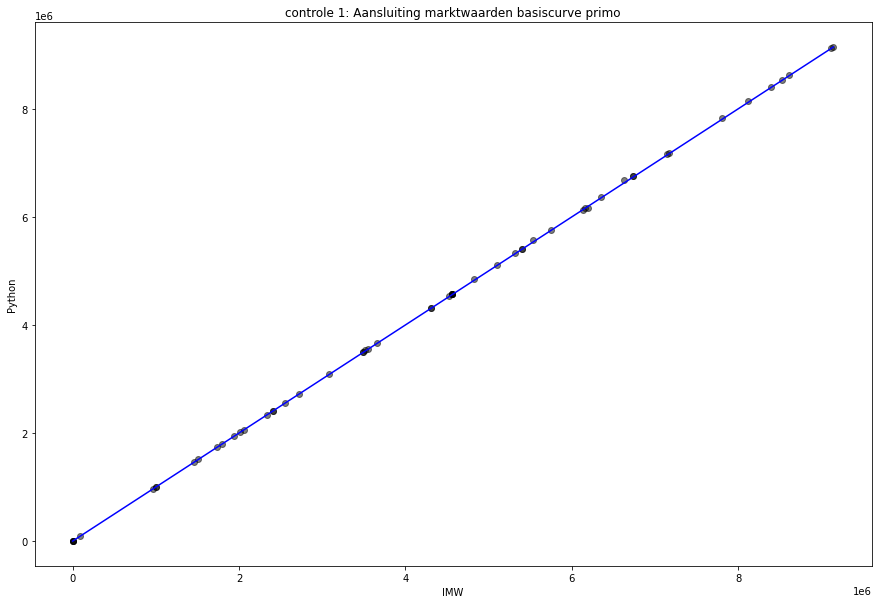

In [56]:
lineStart = df_swaptionsAoC['marketValueModelPrimo'].min() 
lineEnd = df_swaptionsAoC['marketValueModelPrimo'].max()
plt.figure(figsize=(15,10))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], color = 'b')
plt.scatter(df_swaptionsAoC['marketValueIMWPrimo'], df_swaptionsAoC['marketValueModelPrimo'], color = 'k', alpha=0.5)
plt.title('controle 1: Aansluiting marktwaarden basiscurve primo')
plt.xlabel('IMW')
plt.ylabel('Python')
plt.show

### Marktwaarden Python vs IMW basiscurve ultimo

<function matplotlib.pyplot.show(close=None, block=None)>

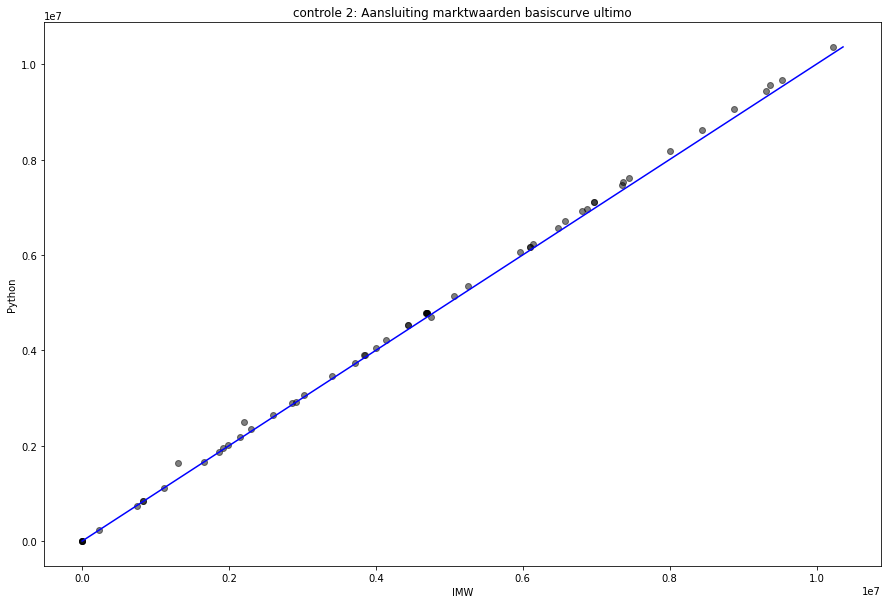

In [57]:
lineStart = df_swaptionsAoC['marketValueModelUltimo'].min() 
lineEnd = df_swaptionsAoC['marketValueModelUltimo'].max()
plt.figure(figsize=(15,10))
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], color = 'b')
plt.scatter(df_swaptionsAoC['marketValueIMWUltimo'], df_swaptionsAoC['marketValueModelUltimo'], color = 'k', alpha=0.5)
plt.title('controle 2: Aansluiting marktwaarden basiscurve ultimo')
plt.xlabel('IMW')
plt.ylabel('Python')
plt.show